In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import netCDF4
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
summary_dir = '/Trex/test_case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/summary'
# summary_dir = '/Users/yguo/DataSpellProjects/hw/uhi'


# merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables.feather')
merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables_with_location_ID_event_ID.feather')

local_hour_adjusted_df = pd.read_feather(merged_feather_path)
local_hour_adjusted_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58245960 entries, 8945088 to 56705927
Data columns (total 73 columns):
 #   Column           Dtype         
---  ------           -----         
 0   index            int64         
 1   time             datetime64[ns]
 2   lat              float32       
 3   lon              float32       
 4   APPAR_TEMP       float32       
 5   APPAR_TEMP_R     float32       
 6   APPAR_TEMP_U     float32       
 7   EFLX_LH_TOT      float32       
 8   EFLX_LH_TOT_R    float32       
 9   EFLX_LH_TOT_U    float32       
 10  FGR              float32       
 11  FGR_R            float32       
 12  FGR_U            float32       
 13  FIRA             float32       
 14  FIRA_R           float32       
 15  FIRA_U           float32       
 16  FIRE             float32       
 17  FIRE_R           float32       
 18  FIRE_U           float32       
 19  FLDS             float32       
 20  FSA              float32       
 21  FSA_R            float32    

In [3]:
location_ID_path = os.path.join(summary_dir, 'location_IDs.nc')
location_ID_ds = xr.open_dataset(location_ID_path, engine='netcdf4')

In [4]:
location_ID_ds

<xarray.Dataset> Size: 444kB
Dimensions:      (lon: 288, lat: 192)
Coordinates:
  * lon          (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat          (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
Data variables:
    location_ID  (lat, lon) int64 442kB ...

In [5]:
df_daily_vars = pd.read_excel('../Data/hourlyDataSchema.xlsx')
daily_vars =df_daily_vars.loc[df_daily_vars['X_vars2'] == 'Y', 'Variable']
daily_var_lst = daily_vars.tolist()
daily_var_lst

['EFLX_LH_TOT',
 'FGR',
 'FIRA',
 'FLDS',
 'FSA',
 'FSDS',
 'FSH',
 'PBOT',
 'Q2M',
 'TSA',
 'U10']

In [ ]:
df_daily_vars.info()

In [6]:
# Step 1: Define masks for daytime and nighttime
daytime_mask = local_hour_adjusted_df['local_hour'].between(8, 16)
nighttime_mask = (local_hour_adjusted_df['local_hour'].between(20, 24) |
                  local_hour_adjusted_df['local_hour'].between(0, 4))


In [51]:
daytime_uhi_diff = local_hour_adjusted_df[nighttime_mask]
# nighttime_uhi_diff = local_hour_adjusted_df[nighttime_mask]

X = daytime_uhi_diff[daily_var_lst]
y = daytime_uhi_diff['UHI_diff']

In [ ]:
X.info()
y.info()

#  feature selection

In [ ]:
list(range(X.shape[1]))

In [ ]:
import catboost
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train)
validation_pool = Pool(X_val, y_val)

In [ ]:

# import catboost
# from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# 
# # Split your data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# 
# train_pool = Pool(X_train, y_train)
# validation_pool = Pool(X_val, y_val)

# List to store all summaries
all_summaries = []

# Variables to store the best scores and corresponding number of features
best_score = np.inf
best_num_features = 0

#  Running the feature selection algorithm

In [ ]:

# Test different numbers of features
for num_features in range(1, X_train.shape[1] + 1):
    print(f"Testing with {num_features} features...")

    # Reinitialize your model for each iteration
    model = CatBoostRegressor(
        iterations=100,
        learning_rate=0.1,
        depth=4,
        loss_function='RMSE',
        verbose=False,
        thread_count=58  # Control the number of CPU cores
    )

    summary = model.select_features(
        train_pool,
        features_for_select=list(range(X_train.shape[1])),
        num_features_to_select=num_features,
        steps=num_features-1,  # Adjust this if needed
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        eval_set=validation_pool,
        logging_level='Silent',
        plot=True
    )

    # Add the summary to the list
    all_summaries.append(summary)

    # Check if 'model' key exists in the summary
    if 'model' in summary:
        # Retrieve the model trained with the selected features
        selected_features_model = summary['model']

        # Evaluate the model
        predictions = selected_features_model.predict(validation_pool)
        rmse = mean_squared_error(y_val, predictions, squared=False)

        print(f"RMSE for {num_features} features: {rmse}")

        # Update best score and number of features if current model is better
        if rmse < best_score:
            best_score = rmse
            best_num_features = num_features
    else:
        print(f"No model was trained with {num_features} features.")

print(f"Best number of features: {best_num_features} with RMSE: {best_score}")




In [ ]:
print(f"Best number of features: {best_num_features} with RMSE: {best_score}")

In [ ]:
all_summaries

In [ ]:
import pandas as pd

# Feature names based on your dataset description
# daily_var_lst = ['EFLX_LH_TOT', 'FGR', 'FIRA', 'FLDS', 'FSA', 'FSDS', 'FSH', 'PBOT', 'Q2M', 'TSA', 'U10']

# Prepare a list to fill the DataFrame
data = []

# Iterate over each summary in all_summaries
for summary in all_summaries:
    selected = summary['selected_features_names']
    # Create a row for the current summary, marking 'Y' if selected, 'X' otherwise
    row = ['Y' if feature in selected else '' for feature in daily_var_lst]
    data.append(row)

# Create the DataFrame
df = pd.DataFrame(data, columns=daily_var_lst)

# Display the DataFrame
df


In [31]:
model_cpu = CatBoostRegressor(
    iterations=400,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=False,
    thread_count=58  # Control the number of CPU cores
)



In [32]:
%time
summary = model_cpu.select_features(
    train_pool,
    features_for_select=daily_var_lst,
    num_features_to_select=8,
    steps=6-1,  # Adjust this if needed
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    eval_set=validation_pool,
    logging_level='Silent',
    plot=True
)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 16 µs


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

The number of features selection steps (5) is greater than the number of features to eliminate (3). The number of steps was reduced to 3.


In [ ]:
# model_gpu = CatBoostRegressor(
#     iterations=300,
#     learning_rate=0.1,
#     depth=6,
#     loss_function='RMSE',
#     verbose=False,
#     thread_count=58,  # Control the number of CPU cores
#     task_type="GPU"
# )

In [ ]:

# summary = model_gpu.select_features(
#     train_pool,
#     features_for_select=daily_var_lst,
#     num_features_to_select=8,
#     steps=5,  # Adjust this if needed
#     algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
#     shap_calc_type=EShapCalcType.Regular,
#     train_final_model=True,
#     eval_set=validation_pool,
#     logging_level='Silent',
#     plot=True
# )

In [ ]:
summary

In [33]:
selected_feature_list = summary['selected_features_names']
selected_feature_list

['EFLX_LH_TOT', 'FGR', 'FIRA', 'FSH', 'PBOT', 'Q2M', 'TSA', 'U10']

In [34]:
# Calculate feature importance using SHAP values comparing against reference data
importances = model_cpu.get_feature_importance(
    data=validation_pool,
    type='FeatureImportance',
    #reference_data=train_pool
)
importances


In [35]:
importances


array([14.77142729,  7.11823052, 11.46299815,  0.        ,  0.        ,
        0.        , 17.5737481 ,  7.20930641, 16.80543992,  6.72963179,
       18.32921781])

In [36]:
# Assuming you have a list of feature names corresponding to the columns in your data
feature_names = validation_pool.get_feature_names()
# Assuming 'ShortName' is the column with the feature codes, and 'LongName' is the column with the descriptions
feature_name_mapping = pd.Series(df_daily_vars['Long Name'].values, index=df_daily_vars['Variable']).to_dict()
# feature_name_mapping
long_feature_names = [feature_name_mapping.get(name, "Unknown Feature") for name in feature_names]
# long_feature_names
# Create a DataFrame for easy plotting
# Create a DataFrame for the importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Long Name': long_feature_names
})

In [ ]:
importance_df

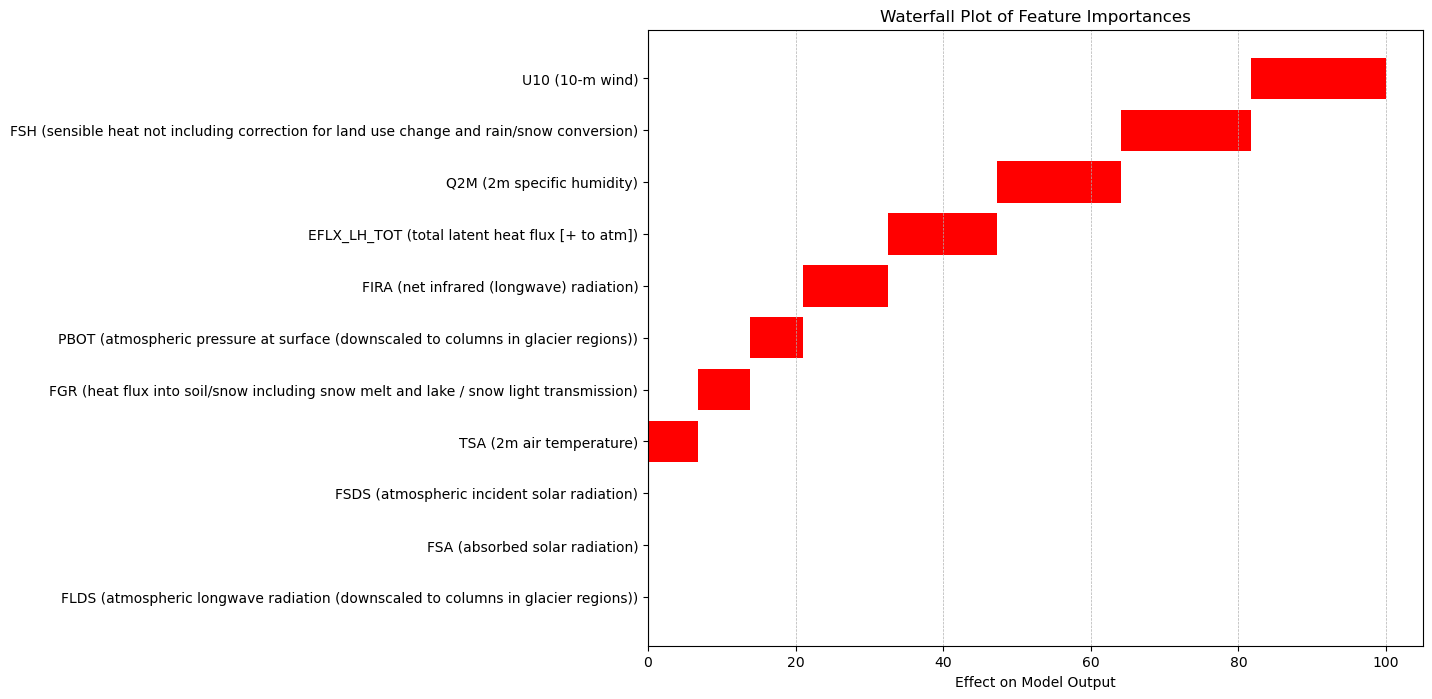

In [37]:
import numpy as np
import matplotlib.pyplot as plt
importance_df.sort_values(by='Importance', ascending=True, inplace=True)

# Cumulative sums for the waterfall effect
importance_df['Start'] = importance_df['Importance'].cumsum() - importance_df['Importance']
importance_df['End'] = importance_df['Importance'].cumsum()

# Setup plot
fig, ax = plt.subplots(figsize=(10, 8))

# Adding bars for each feature
for index, row in importance_df.iterrows():
    ax.barh(row['Feature'] + ' (' + row['Long Name'] + ')', row['Importance'], left=row['Start'],
            color='red' if row['Importance'] >= 0 else 'blue')
    
# Plot styling to match the example
ax.axvline(x=0, color='grey', linewidth=0.8)
ax.set_xlabel('Effect on Model Output')
ax.set_title('Waterfall Plot of Feature Importances')
plt.grid(True, axis='x', linestyle='--', linewidth=0.5)
plt.show()

#   SHAP waterfall plot

In [38]:
import shap

# Create an object that can calculate shap values
explainer = shap.TreeExplainer(model_cpu, feature_names=long_feature_names)

# Calculate SHAP values for the validation dataset
# You can choose a specific instance by indexing into the validation pool, e.g., validation_pool[0]
shap_values = explainer.shap_values(validation_pool)
shap_values

In [39]:
shap_values

array([[-0.02858489,  0.06589747, -0.01804325, ...,  0.00901959,
         0.02767394, -0.13139374],
       [ 0.07879633, -0.06621213, -0.00795809, ...,  0.00975571,
        -0.0088763 ,  0.03825663],
       [ 0.00943956,  0.10595364,  0.15973101, ...,  0.02361819,
        -0.03254848, -0.11885683],
       ...,
       [-0.05822923, -0.01984935, -0.00490305, ...,  0.03994339,
         0.00472559, -0.0372687 ],
       [-0.06899672, -0.07344374, -0.03019772, ...,  0.04205965,
         0.00132351,  0.08633708],
       [-0.05092103, -0.00633846, -0.01799915, ...,  0.00117908,
         0.01602888, -0.05573582]])

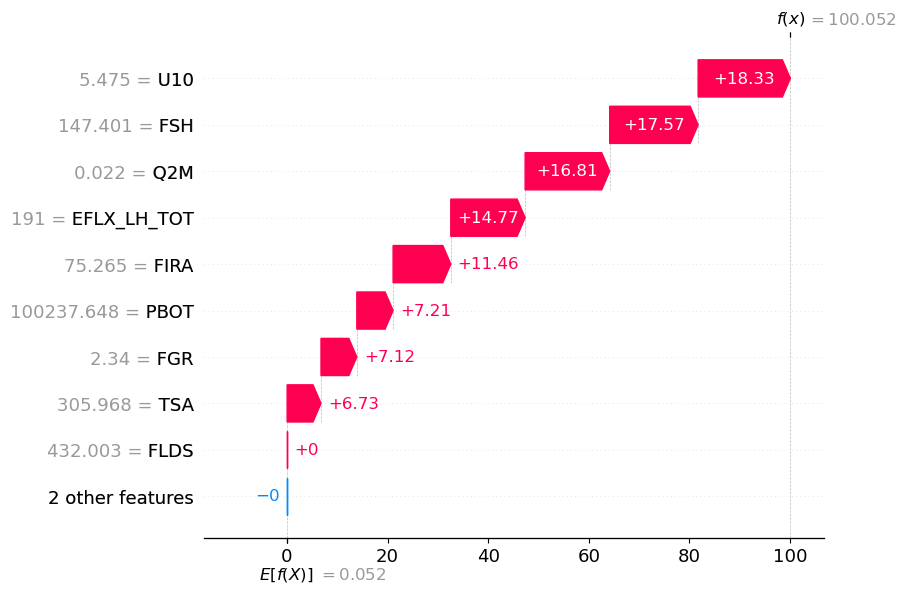

In [40]:

# Plot the SHAP values for the first instance in the validation dataset
shap.waterfall_plot(shap.Explanation(importances, base_values=explainer.expected_value, data=validation_pool.get_features()[0], feature_names=validation_pool.get_feature_names()))



In [41]:
from catboost import CatBoostRegressor

# Initialize the CatBoostRegressor (or CatBoostClassifier, depending on your task)
model_all_cols = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=5,
                          loss_function='RMSE',
                          eval_metric='RMSE',
                          random_seed=42,
                          verbose=False)

# Train the model
model_all_cols.fit(X_train, y_train,
          eval_set=(X_val, y_val),
          use_best_model=True,
          early_stopping_rounds=50)


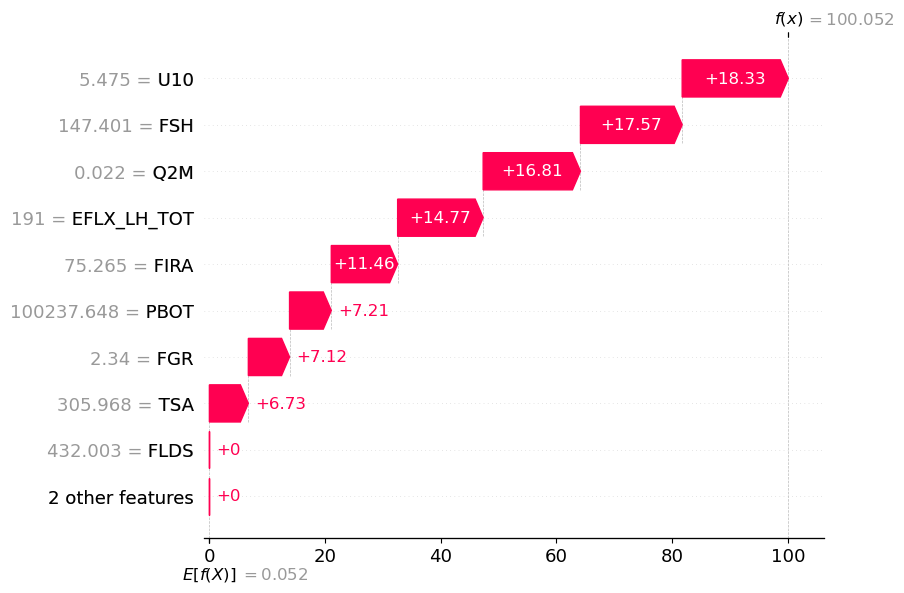

In [42]:
import shap

# Create an object that can calculate shap values
explainer = shap.TreeExplainer(model_all_cols, feature_names=long_feature_names)

# Calculate SHAP values for the validation dataset
# You can choose a specific instance by indexing into the validation pool, e.g., validation_pool[0]
shap_values = explainer.shap_values(validation_pool)
shap_values
shap.waterfall_plot(shap.Explanation(importances, base_values=explainer.expected_value, data=validation_pool.get_features()[0], feature_names=validation_pool.get_feature_names()))

#  Night Data

In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import shap

def train_and_evaluate(local_hour_adjusted_df, time_mask, daily_var_lst, long_feature_names):
    # Filter dataframe for daytime data
    time_uhi_diff = local_hour_adjusted_df[time_mask]

    # Select features and target
    X = time_uhi_diff[daily_var_lst]
    y = time_uhi_diff['UHI_diff']

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_pool = Pool(X_train, y_train)
    validation_pool = Pool(X_val, y_val)

    # Train the final model with all columns on selected features after feature selection
    model = CatBoostRegressor(
        iterations=100,
        learning_rate=0.05,
        depth=5,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        verbose=False
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val),
                       use_best_model=True, early_stopping_rounds=50, plot=True)
    return model



    # Calculate SHAP values
    explainer = shap.TreeExplainer(model, feature_names=long_feature_names)
    shap_values = explainer.shap_values(validation_pool)
    mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
    # Normalize the SHAP values so that they sum to one
    total = mean_abs_shap_values.sum()
    normalized_shap_values = mean_abs_shap_values / total
    # Plot the SHAP values for the first instance in the validation dataset
    shap.waterfall_plot(shap.Explanation(normalized_shap_values, base_values=explainer.expected_value,
                                         data=validation_pool.get_features()[0],
                                         feature_names=validation_pool.get_feature_names()))

    return model

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

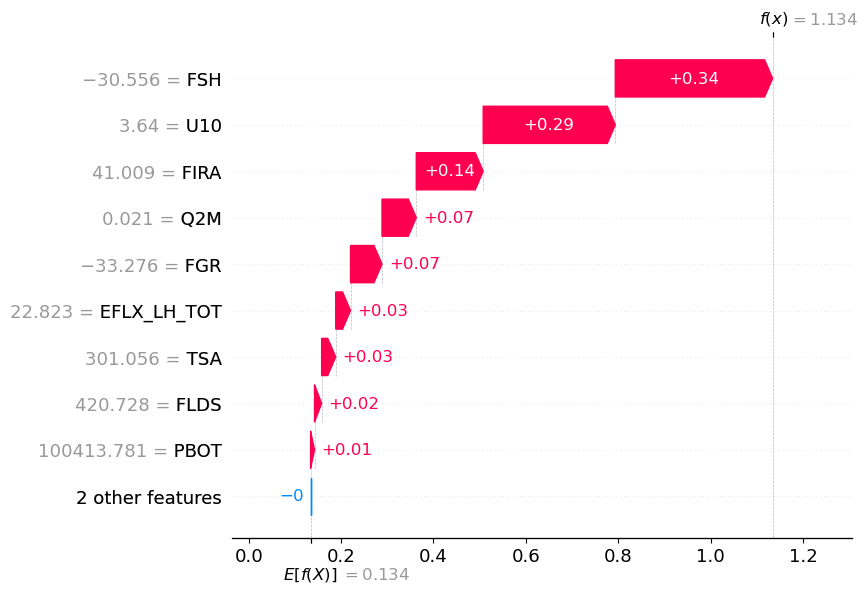

In [68]:
night_model = train_and_evaluate(local_hour_adjusted_df, nighttime_mask, daily_var_lst, long_feature_names)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

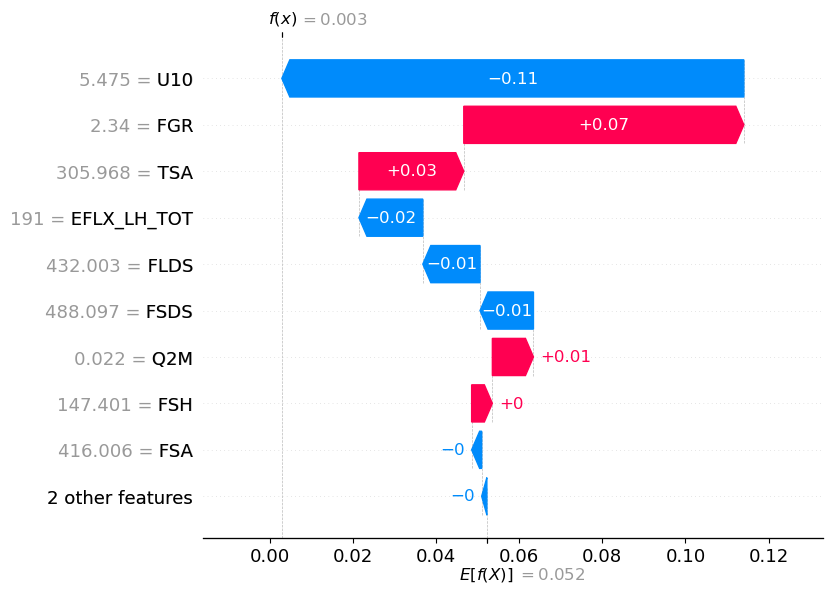

In [53]:
day_model = train_and_evaluate(local_hour_adjusted_df, daytime_mask, daily_var_lst, long_feature_names)

In [56]:
shap_values

array([[-0.01538168,  0.06743123, -0.00204719, ...,  0.0098948 ,
         0.02524067, -0.11123011],
       [ 0.06562965, -0.07663896,  0.00521776, ...,  0.01221502,
        -0.00404986,  0.04939751],
       [ 0.01244539,  0.13061001,  0.11022936, ...,  0.01304565,
        -0.06163441, -0.05729936],
       ...,
       [-0.03853866, -0.01998231, -0.006815  , ...,  0.04382386,
         0.0083345 , -0.0351058 ],
       [-0.05061123, -0.11268693, -0.01590528, ...,  0.04307091,
         0.00544024,  0.09542512],
       [-0.0470534 ,  0.00015054, -0.00739321, ...,  0.00611617,
         0.01057168, -0.0616246 ]])

In [61]:
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
mean_abs_shap_values
# Normalize the SHAP values so that they sum to one
total = mean_abs_shap_values.sum()
normalized_shap_values = mean_abs_shap_values / total

In [64]:
normalized_shap_values

array([0.11212723, 0.11717263, 0.05515867, 0.03807134, 0.0135555 ,
       0.05641644, 0.11723812, 0.07025633, 0.15024716, 0.07548088,
       0.19427572])

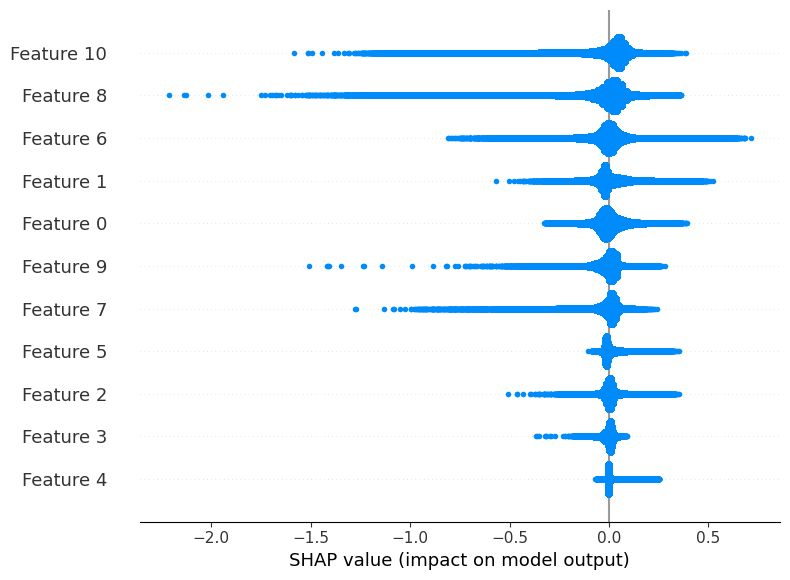

In [69]:
shap.summary_plot(shap_values)

In [82]:
# Get feature importance
day_feature_importances = day_model.get_feature_importance(type='FeatureImportance')
day_feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': day_feature_importances})
print(day_feature_importance_df.sort_values(by='Importance', ascending=False))


        Feature  Importance
10          U10   20.331508
8           Q2M   16.847988
6           FSH   16.037332
0   EFLX_LH_TOT   12.972282
2          FIRA    8.220446
7          PBOT    6.389783
1           FGR    6.112123
9           TSA    5.926221
5          FSDS    3.537228
3          FLDS    2.794724
4           FSA    0.830365


In [72]:
# Get feature importance
feature_importances = night_model.get_feature_importance(type='FeatureImportance')
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))


        Feature  Importance
6           FSH   37.381935
10          U10   28.925892
2          FIRA   12.020182
8           Q2M    7.543470
1           FGR    5.400510
9           TSA    3.357824
0   EFLX_LH_TOT    3.024580
3          FLDS    1.479003
7          PBOT    0.866604
4           FSA    0.000000
5          FSDS    0.000000


In [79]:
feature_importance_df.sum()

Feature       EFLX_LH_TOTFGRFIRAFLDSFSAFSDSFSHPBOTQ2MTSAU10
Importance                                            100.0
dtype: object

In [76]:
df_daily_vars

,Variable,Long Name,Units,Cell Methods,Fill Value,Missing Value,X_vars,X_vars2,X_selected,Notes
0,area,grid cell areas,km^2,NaN,1.e+36f,1.e+36f,NaN,NaN,NaN,NaN
1,landfrac,land fraction,NaN,NaN,1.e+36f,1.e+36f,NaN,NaN,NaN,NaN
2,landmask,land/ocean mask (0.=ocean and 1.=land),NaN,NaN,-9999,-9999,NaN,NaN,NaN,NaN
3,pftmask,pft real/fake mask (0.=fake and 1.=real),NaN,NaN,-9999,-9999,NaN,NaN,NaN,NaN
4,nbedrock,index of shallowest bedrock layer,NaN,NaN,-9999,-9999,NaN,NaN,NaN,NaN
5,APPAR_TEMP,2 m apparent temperature,C,time: mean,1.e+36f,1.e+36f,NaN,NaN,NaN,NaN
6,APPAR_TEMP_R,Rural 2 m apparent temperature,C,time: mean,1.e+36f,1.e+36f,NaN,NaN,NaN,NaN
7,APPAR_TEMP_U,Urban 2 m apparent temperature,C,time: mean,1.e+36f,1.e+36f,NaN,NaN,NaN,NaN
8,EFLX_LH_TOT,total latent heat flux [+ to atm],W/m^2,time: mean,1.e+36f,1.e+36f,Y,Y,Y,NaN
9,EFLX_LH_TOT_R,Rural total evaporation,W/m^2,time: mean,1.e+36f,1.e+36f,Y,NaN,NaN,NaN


In [77]:
daily_vars

8     EFLX_LH_TOT
11            FGR
14           FIRA
20           FLDS
21            FSA
24           FSDS
25            FSH
32           PBOT
33            Q2M
41            TSA
47            U10
Name: Variable, dtype: object